In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))


# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv']


In [2]:
# importing some libraries for visulizations
import matplotlib.pyplot as plt
import seaborn as sns

# importing sklearn to select the model that will be fitting out data into
# we will train_test_split to divide the data
# we will use cross_val_score to determine best accuracy 
from sklearn.model_selection import train_test_split, cross_val_score

# import the data into dataframes using pandas library
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsdupe = idsTotal - idsUnique
print(idsdupe)


0


In [5]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'],axis =1,inplace=True)
test.drop(['Id'],axis =1,inplace=True)

Skewness: 1.88
Kurtosis: 6.54


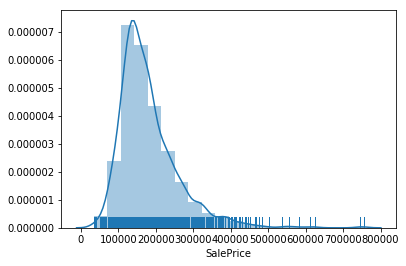

In [6]:
%matplotlib inline
sns.distplot(train['SalePrice'], bins=20, rug=True)

print("Skewness: %0.2f" %train['SalePrice'].skew())
print("Kurtosis: %0.2f" %train['SalePrice'].kurt())
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


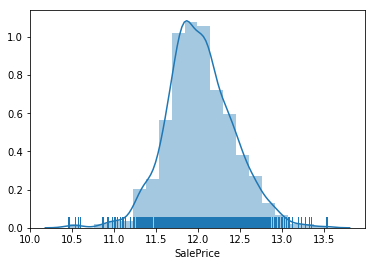

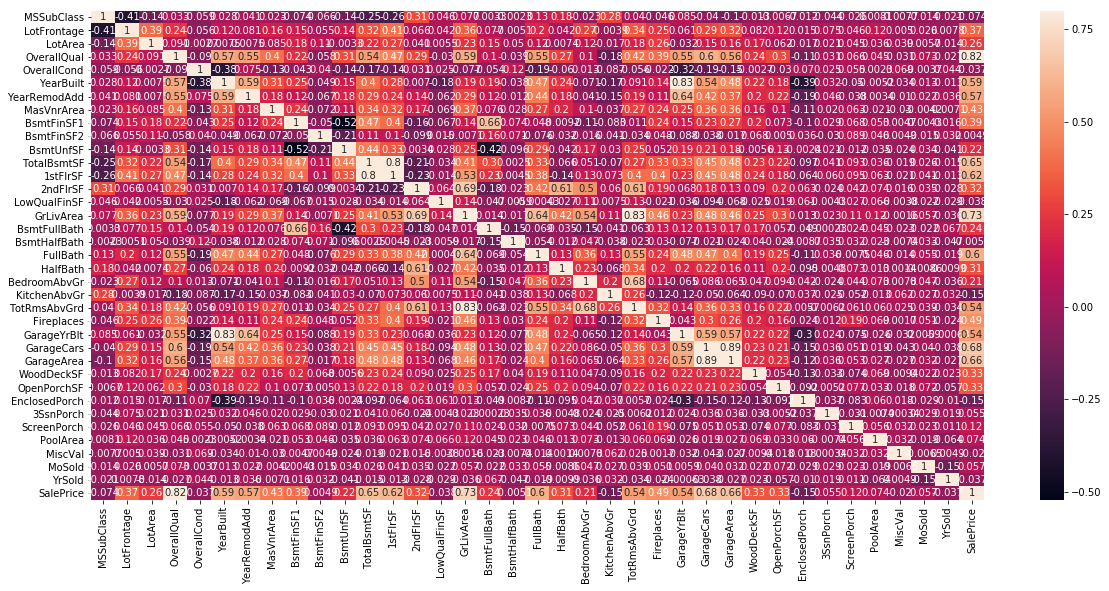

In [7]:
%matplotlib inline
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'], bins=20, rug=True)
corrmat = train.corr()
plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

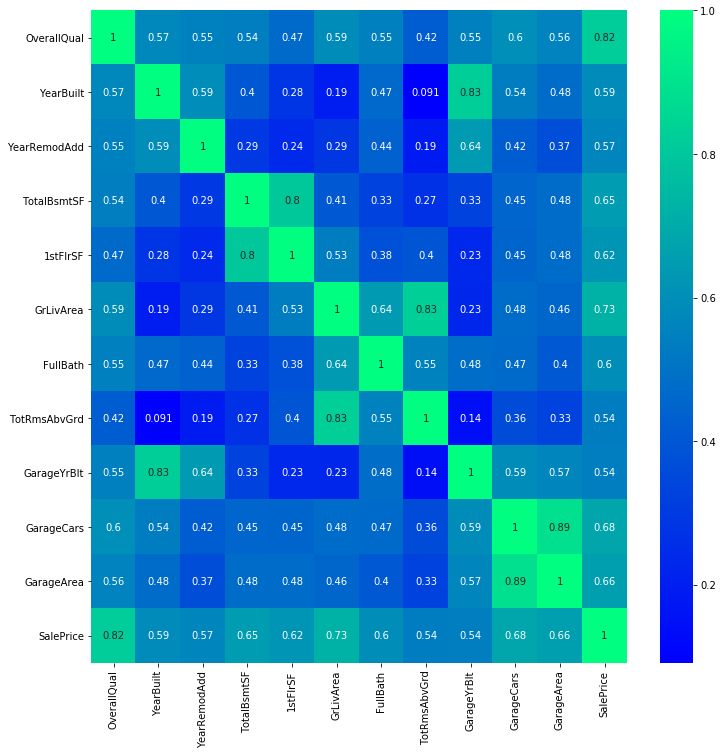

In [8]:
corrmat = train.corr()
# extracting the relevant features
filteredCorrMat_features = corrmat.index[abs(corrmat['SalePrice'])>=0.5]
plt.figure(figsize=(12,12))
# performing corr on the chosen features and presenting it on the heatmap
sns.heatmap(train[filteredCorrMat_features].corr(),annot=True,cmap='winter')

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))


all_data size is : (2917, 79)


In [10]:
totalMissing = all_data.isnull().sum().sort_values(ascending=False)
percentage = ((all_data.isnull().sum()/all_data.isnull().count())*100).sort_values(ascending=False)

missingData = pd.concat([totalMissing,percentage],axis=1,keys=['Total','Percentage'])
missingData.head(20)

,Total,Percentage
PoolQC,2908,99.691464
MiscFeature,2812,96.400411
Alley,2719,93.212204
Fence,2346,80.425094
FireplaceQu,1420,48.680151
LotFrontage,486,16.660953
GarageFinish,159,5.450806
GarageQual,159,5.450806
GarageYrBlt,159,5.450806
GarageCond,159,5.450806


In [11]:
# columns to be dropped


columnsToDrop = missingData[missingData['Percentage']>50].index

all_data = all_data.drop(columnsToDrop, axis=1)

len(all_data.columns)

75

In [12]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2',
            'GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond', 'FireplaceQu', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

In [13]:
#GarageYrBlt replacing missing data with 0
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

# NA most likely means no masonry veneer for these houses. We can fill in 0
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# Electrical has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [49]:
all_data.isnull().sum().sort_values(ascending=False) #check


KitchenAbvGr           1461
ScreenPorch            1461
PoolArea               1461
LotArea                1461
Condition1_Feedr          0
Condition1_Artery         0
Exterior1st_AsbShng       0
Electrical_SBrkr          0
Electrical_Mix            0
Electrical_FuseP          0
Electrical_FuseF          0
Electrical_FuseA          0
Condition2_RRNn           0
Condition2_RRAn           0
Condition2_RRAe           0
CentralAir_Y              0
Condition2_PosN           0
Condition1_Norm           0
Condition2_PosA           0
Exterior1st_AsphShn       0
Condition2_Feedr          0
Condition2_Artery         0
Condition1_RRNn           0
Condition1_RRNe           0
Condition1_RRAn           0
Condition1_RRAe           0
Condition1_PosN           0
Condition1_PosA           0
Condition2_Norm           0
Street_Pave               0
                       ... 
Foundation_PConc          0
HouseStyle_2.5Unf         0
HouseStyle_2Story         0
HouseStyle_SFoyer         0
LotShape_IR1        

In [21]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [24]:
#deleting uncorrelate colomns
unCorrColumns = ['EnclosedPorch', 'OverallCond', 
        'YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2','3SsnPorch']

train.drop(unCorrColumns,axis=1,inplace=True)

In [25]:
from pandas.api.types import is_numeric_dtype
def remove_outliers(df):
    low = .05
    high = .9
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

remove_outliers(train).head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition,SalePrice


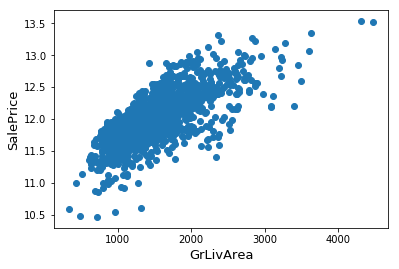

In [26]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [28]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

In [30]:
from scipy.stats import skew 

# extracting numerical features
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
numeric_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :numeric_features})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [33]:
highly_skewed = ['PoolArea','LotArea','KitchenAbvGr','ScreenPorch','MiscVal','3SsnPorch','LowQualFinSF']

from scipy.special import boxcox1p
lam = 0.15
for feat in highly_skewed:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [32]:
train = pd.get_dummies(train)
print(train.shape)

(1458, 278)


In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 48 skewed numerical features to Box Cox transform


In [35]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [36]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,16.977559
3SsnPorch,8.767488
LowQualFinSF,8.459291
MiscVal,5.117438
BsmtHalfBath,3.786685
ScreenPorch,3.108265
BsmtFinSF2,2.563235
EnclosedPorch,2.024321
KitchenAbvGr,1.169175
MasVnrArea,0.637388


In [37]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 49 skewed numerical features to Box Cox transform


In [38]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 228)


In [39]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [40]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [41]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [42]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [43]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [44]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [45]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [46]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [47]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [48]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').